In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [3]:
NUM_TRADING_DAYS = 252
NUM_PORTFOLIOS = 10000

In [4]:
def download_data(ticker,start_date,end_date):
    ticker = yf.Ticker(ticker)
    historic_data = ticker.history(start=start_date,end=end_date)['Close']
    return historic_data

In [5]:
def visualize_dataset(dataset):
    dataset.plot(figsize=(10,5))
    plt.show()

In [6]:
#logarithmic returns are prefered for normalization of the data
def calculate_logarithmic_returns(dataset):
    log_return = np.log(dataset/dataset.shift(1))
    #first rows turn into NaN values after computation,thus returning from second row onwards.
    return log_return[1:]

In [7]:
def print_stats_for_data(dataset):
    print(f'Mean: {dataset.mean()*NUM_TRADING_DAYS}')
    print(f'Covariance: {dataset.cov()*NUM_TRADING_DAYS}')

In [8]:
#calculate the expected mean for the portfolio.with allocated wights for each constituent
def print_mean_variance_for_data(dataset,weights):
    portfolio_returns = np.sum(dataset.mean()*weights)*NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(dataset.cov()*NUM_TRADING_DAYS,weights)))
    print(f'Expected returns: {portfolio_returns}')
    print(f'Portfolio Volatility: {portfolio_volatility}')

In [93]:
def calculate_portfolios_stats(dataset,weights):
    portfolio_returns = np.sum(dataset.mean()*weights)*NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(dataset.cov()*NUM_TRADING_DAYS,weights)))
    return np.array([portfolio_returns,portfolio_volatility,portfolio_returns/portfolio_volatility])

In [73]:
#scipy optimize module can find the minimum of a given function
#the maximum of a f(x) is the minimum of -f(x)
def minimise_sharpe_ratio(weights,dataset):
    return -calculate_portfolios_stats(dataset,weights)[2]

In [68]:
#f(x)=0 this is the function to minimize
def optimize_portfolio(dataset,weights,num_of_stocks):
    # the sum of the edge weights should be equal to 1
    constraints = {'type':'eq','fun':lambda x:np.sum(x)-1}
    # the weights can be 1 at most: 1 when 100% of the money is invested into a single stock
    bounds = tuple((0,1)for _ in range(num_of_stocks))
    optimal_portfolio=optimization.minimize(fun=minimise_sharpe_ratio,x0=weights[0],args=dataset,method='SLSQP',bounds=bounds,constraints=constraints)
    return optimal_portfolio

In [91]:
def print_optimal_portfolio(averages,portfolio):
    print('Optimal portfolio',portfolio['x'].round(4))
    print('Expected returns,volatility and Sharpe ratio: ',calculate_portfolios_stats(averages,portfolio['x'].round(3)))

In [106]:
def plot_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(calculate_portfolios_stats(rets,opt['x'])[1], calculate_portfolios_stats(rets,opt['x'])[0], 'g*', markersize=20.0)
    plt.show()

In [35]:
def generate_random_portfolios(dataset,number_of_stocks):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    for _ in range(NUM_PORTFOLIOS):
        weights = np.random.random(number_of_stocks)
        #normalize weights for sum to result in 1
        weights/=np.sum(weights)
        portfolio_weights.append(weights)
        portfolio_returns = np.sum(dataset.mean()*weights)*NUM_TRADING_DAYS
        portfolio_means.append(portfolio_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(dataset.cov()*NUM_TRADING_DAYS,weights)))
        portfolio_risks.append(portfolio_volatility)
    return np.array(portfolio_weights),np.array(portfolio_means),np.array(portfolio_risks)

In [40]:
def plot_portfolios(means,volatilities):
    plt.figure(figsize=(10,6))
    plt.scatter(volatilities,means,c=means/volatilities,marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [11]:
start_date = '2018-01-01'
end_date = '2023-01-01'
stocks = ['TATAMOTORS.NS','SBIN.NS','ITC.NS','OFSS.NS','BHARTIARTL.NS']
stock_data = {}
for stock in stocks:
    stock_data[stock] = download_data(stock,start_date,end_date)

In [12]:
df = pd.DataFrame(stock_data)

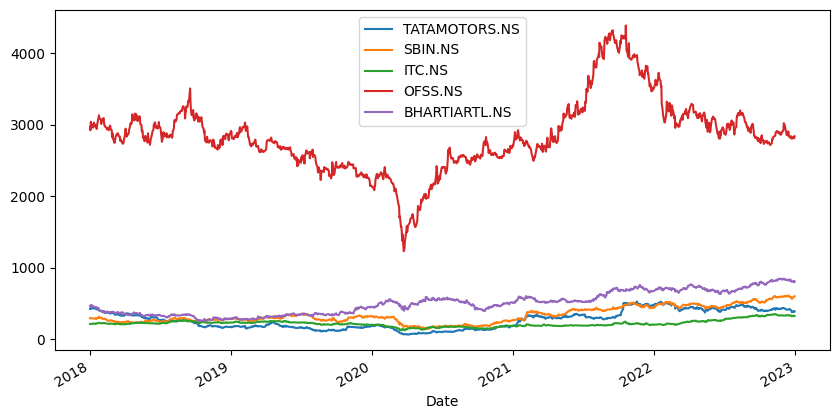

In [13]:
visualize_dataset(df)

In [14]:
log_daily_returns = calculate_logarithmic_returns(df)

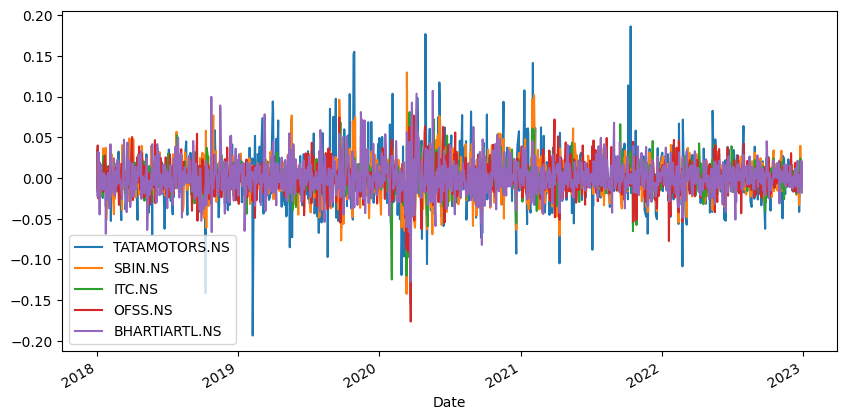

In [15]:
visualize_dataset(log_daily_returns)

In [16]:
print_stats_for_data(log_daily_returns)

Mean: TATAMOTORS.NS   -0.018348
SBIN.NS          0.146305
ITC.NS           0.085539
OFSS.NS         -0.009332
BHARTIARTL.NS    0.109681
dtype: float64
Covariance:                TATAMOTORS.NS   SBIN.NS    ITC.NS   OFSS.NS  BHARTIARTL.NS
TATAMOTORS.NS       0.240495  0.083611  0.043472  0.034010       0.049031
SBIN.NS             0.083611  0.127467  0.040216  0.027542       0.040151
ITC.NS              0.043472  0.040216  0.071315  0.017587       0.024048
OFSS.NS             0.034010  0.027542  0.017587  0.088643       0.025439
BHARTIARTL.NS       0.049031  0.040151  0.024048  0.025439       0.112647


In [17]:
print_mean_variance_for_data(log_daily_returns,np.array([0.25,0.25,0.15,0.15,0.20]))

Expected returns: 0.06535657518389935
Portfolio Volatility: 0.2551977664217272


In [36]:
weights,means,risks = generate_random_portfolios(log_daily_returns,len(stocks))

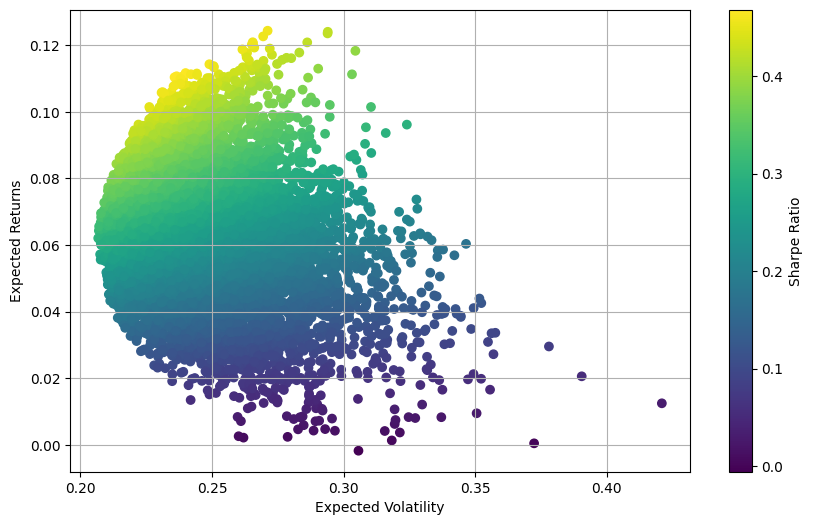

In [41]:
plot_portfolios(means,risks)

In [74]:
optimal_portfolio = optimize_portfolio(log_daily_returns,weights,len(stocks))

In [94]:
print_optimal_portfolio(log_daily_returns,optimal_portfolio)

Optimal portfolio [0.     0.4106 0.2915 0.     0.2979]
Expected returns,volatility and Sharpe ratio:  [0.11779353 0.2475666  0.47580543]


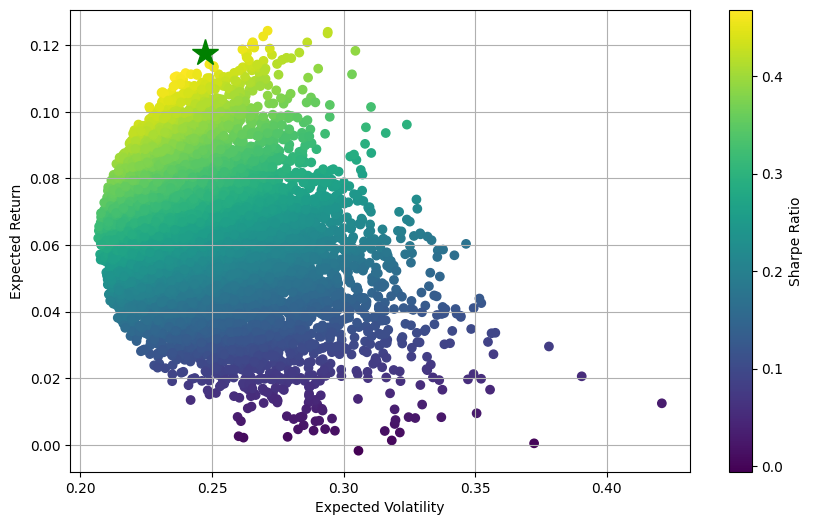

In [107]:
plot_optimal_portfolio(optimal_portfolio,log_daily_returns,means,risks)